## 1. Import Standard Libraries

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F

## 2. Get the Data

In [4]:
mnist = pd.read_csv("Mnist_combined.csv" ,index_col= 0)

In [5]:
mnist.head(3)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
mnist.tail(3)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9999,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
mnist.shape

(70000, 785)

## 3. Convert the Data into Tensor Dataset

In [8]:
X = mnist.drop(labels = "label" ,axis = 1)
Y = mnist["label"]

In [9]:
data_np = X.to_numpy()
labels_np = Y.to_numpy()

In [10]:
data_np[0].shape

(784,)

In [11]:
labels_np.shape

(70000,)

In [12]:
# normalize the data to a range of [0 1]
dataNorm = data_np / np.max(data_np)

In [13]:
dataNorm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Converting Numpy array to Pytorch Array

In [14]:
# convert to a pytorch tensor
data = torch.tensor(data_np).float()

# Note: "long" format for CCE : Multiclass classification
labels = torch.tensor(labels_np).long() 

#### Train and Test Loader

In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [16]:
# scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Finally, translate into dataloader objects

batchsize    = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True  ,drop_last=True)
test_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0] ) 

## 4. Create ANN Model

In [17]:
# create a class for the model

def createTheMNISTNet(n_neurons,nLayers,LR):
    
    class MNISTNet(nn.Module):

        # Constructor    
        def __init__(self,n_neurons,nLayers):

            super().__init__()

            # Create dictionary to store the layers
            self.layers = nn.ModuleDict()
            self.nLayers = nLayers

            ### Input layer
            self.layers['input'] = nn.Linear(784,n_neurons)

            ### Defining Hidden layers
            for i in range(nLayers):

                self.layers[f'hidden{i}'] = nn.Linear(n_neurons,n_neurons)

            ### Output layer
            self.layers['output'] = nn.Linear(n_neurons,10)


        # forward pass
        def forward(self,x):

            # Passing Data through input layer 
            x = F.relu( self.layers['input'](x) )

            # Passing Data through Hidden layers
            for i in range(self.nLayers):

                x = F.relu( self.layers[f'hidden{i}'](x) )

            # Passing Data through Output layer
            x = self.layers['output'](x)

            return x
        
    # create the model instance
    ANN_model = MNISTNet(n_neurons,nLayers)

    # loss function 
    lossfunc = lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANN_model.parameters(),lr=LR)
    
    return ANN_model,lossfunc,optimizer

In [18]:
# Generate an instance of the model and inspect it.

n_neurons_PerLayer = 12
nLayers = 4

net = createTheMNISTNet(n_neurons = n_neurons_PerLayer,nLayers = nLayers,LR = .01)[0]
net

MNISTNet(
  (layers): ModuleDict(
    (input): Linear(in_features=784, out_features=12, bias=True)
    (hidden0): Linear(in_features=12, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=10, bias=True)
  )
)

## 5. Model Training

In [19]:
def function2trainTheModel(Model , lossfunc , optimizer ,train_loader , test_loader , epochs):

    losses   = torch.zeros(epochs)
    trainAcc = []
    testAcc  = []
    
    # loop over epochs
    for epochi in range(epochs):
         
        # switch on training mode
        Model.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
    
        # Batch Training
        for X,y in train_loader:

            # Forward pass and loss
            yHat_train = Model(X)
            loss = lossfunc(yHat_train,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batchLoss.append(loss.item())

            # Compute accuracy
            matches = torch.argmax(yHat_train,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
            batchAcc.append( accuracyPct )               # add to list of accuracies
        # End of batch loop...

        # Now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.round(np.mean(batchAcc),2 ))

        # Get average losses across the batches
        losses[epochi] = np.round(np.mean(batchLoss),2)

        # test accuracy
        Model.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad():         # deactivates autograd
            yHat_test = Model(X)
      
        # compare the following really long line of code to the training accuracy lines
        testAcc.append( np.round(100*torch.mean((torch.argmax(yHat_test,axis=1)==y).float()),2 ) )
        # End epochs

    # function output
    return trainAcc,testAcc,losses,Model

## 6. Parametric Study

In [20]:
# Run the experiment! (note: takes - 2hrs)

# Define the model parameters
numlayers = range(1,4)                     # number of hidden layers
neurons_PerLayer  = np.arange(50,201,50)   # units per hidden layer

# initialize output matrices
accuracies  = np.zeros((2,len(neurons_PerLayer),len(numlayers)))

# start the experiment!
for neuronidx in range(len(neurons_PerLayer)):
    
    for layeridx in range(len(numlayers)):
        
        ANN_model,Lossfunc,Optimizer = createTheMNISTNet(n_neurons = neurons_PerLayer[neuronidx],
                                                         nLayers = numlayers[layeridx],
                                                         LR = .01)
        
        TrainAcc,TestAcc,Losses,trained_Model = function2trainTheModel(Model = ANN_model  ,
                                                                       lossfunc = Lossfunc ,
                                                                       optimizer = Optimizer,
                                                                       train_loader = train_loader,
                                                                       test_loader = test_loader ,
                                                                       epochs = 20)
        
   

        # store the results (average of final 5 epochs)
        accuracies[0,neuronidx,layeridx] = np.mean(TrainAcc[-5:])
        accuracies[1,neuronidx,layeridx] = np.mean(TestAcc[-5:])

        # print a friendly status message
        print(f'Finished Units :  {neuronidx+1}/{len(neurons_PerLayer)}\
               \nFinished Layers: {layeridx+1}/{len(numlayers)}') 


Finished Units :  1/4               
Finished Layers: 1/3
Finished Units :  1/4               
Finished Layers: 2/3
Finished Units :  1/4               
Finished Layers: 3/3
Finished Units :  2/4               
Finished Layers: 1/3
Finished Units :  2/4               
Finished Layers: 2/3
Finished Units :  2/4               
Finished Layers: 3/3
Finished Units :  3/4               
Finished Layers: 1/3
Finished Units :  3/4               
Finished Layers: 2/3
Finished Units :  3/4               
Finished Layers: 3/3
Finished Units :  4/4               
Finished Layers: 1/3
Finished Units :  4/4               
Finished Layers: 2/3
Finished Units :  4/4               
Finished Layers: 3/3


In [21]:
# print a friendly status message
print(f'Finished Units :  {1}/{2}\
               \nFinished Layers: {1}/{2}') 

Finished Units :  1/2               
Finished Layers: 1/2


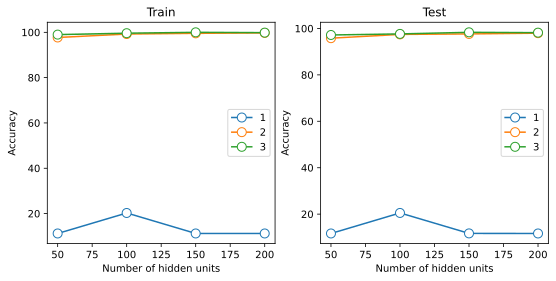

In [23]:
# show accuracy as a function of model depth
fig,ax = plt.subplots(1,2,figsize=(9,4))

ax[0].plot(neurons_PerLayer,accuracies[0,:,:],'o-',markerfacecolor='w',markersize=9)
ax[1].plot(neurons_PerLayer,accuracies[1,:,:],'o-',markerfacecolor='w',markersize=9)

for i in range(2):
    
    ax[i].legend(numlayers)
    ax[i].set_ylabel('Accuracy')
    ax[i].set_xlabel('Number of hidden units')
    ax[i].set_title([ 'Train' if i==0 else 'Test' ][0])

plt.show()